Keras 패키지는 Theano 또는 TensorFlow를 계산 엔진으로 사용하는 파이썬 패키지다. 신경망을 구성하기 위한 각 구성요소를 클래스로 제공하기 때문에 이를 간단히 연결하기만 하면 쉽게 신경망을 구현할 수 있다. 이 글에서는 버전 텐서플로우 2.0-beta에 추가된 케라스 2.2.4-tf 버전을 기준으로 설명한다.

In [1]:
# 코랩에서는 다음 코드로 베타버전을 설치한다.
!pip install tensorflow-gpu==2.0.0-beta1

In [2]:
import tensorflow as tf
tf.__version__

'2.0.0-beta1'

In [3]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

## 예제 데이터

Keras는 다음과 같은 샘플데이터를 제공한다.

+ CIFAR10 이미지

  + 10 종류의 카테고리 라벨을 가지는 50,000 개의 32x32 해상도 컬러 트레이닝 이미지와 10,000 개의 테스트 이미지

+ CIFAR100 이미지

  + 100 종류의 카테고리 라벨을 가지는 50,000 개의 32x32 해상도 컬러 트레이닝 이미지와 10,000 개의 테스트 이미지

+ IMDB 영화 감상

  + positive/negative 라벨을 가지는 25,000 영화 감상 데이터
  + 텍스트 단어는 숫자로 인코딩되어 있음

+ 로이터 뉴스 토픽

  + 46 종류의 토픽 라벨을 가지는 11,228 개의 로이터 뉴스 텍스트
  + 텍스트 단어는 숫자로 인코딩되어 있음

+ MNIST 숫자 이미지

  + 0부터 9까지의 숫자에 대한 28x28 단색 이미지
  + 트레이딩 데이터 60,000개. 테스트 이미지 10,000개

+ MNIST 패션 이미지

  + 10 종류의 의류 대한 28x28 단색 이미지
  + 트레이딩 데이터 60,000개. 테스트 이미지 10,000개
+ Boston housing price

  + 보스턴 주택 가격 데이터

Keras를 사용하는 방법은 어렵지 않기 때문에 바로 MNIST 데이터를 이용해 신경망을 구현하는 예를 보인다.


In [0]:
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

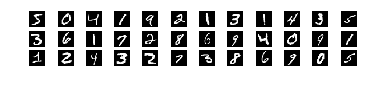

In [5]:
mnist = keras.datasets.mnist
(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

plt.figure(figsize=(6, 1))
for i in range(36):
  plt.subplot(3, 12, i + 1)
  plt.imshow(X_train0[i], cmap='gray')
  plt.axis('off')
plt.show()

Keras의 MNIST 이미지 데이터는 28x28로 scikit-learn보다 고해상도이다.

In [6]:
print(X_train0.shape, X_train0.dtype)
print(y_train0.shape, y_train0.dtype)
print(X_test0.shape, X_test0.dtype)
print(y_test0.shape, y_test0.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


데이터를 float 타입으로 변환 후 스케일링한다. 이는 이미지를 전처리하는 보편적인 방법 중 하나이다.

In [7]:
X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float32') / 255.0
print(X_train.shape, X_train.dtype)

(60000, 784) float32


정답데이터는 라벨에 해당하는 숫자로 되어 있다.

In [8]:
y_train0[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

이 값을 keras.np_utils.categorical()을 사용하여 원핫인코딩(One-Hot-Encoding)로 변환한다.

In [9]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train0, 10)
Y_test = to_categorical(y_test0, 10)
Y_train[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## 신경망 구현 순서

Keras 를 사용하면 다음과 같은 순서로 신경망을 구성할 수 있다.

1. Sequential 모형 클래스 객체 생성

2. add 메서드로 레이어 추가
+ 입력단부터 순차적으로 추가한다.
+ 레이어는 출력 뉴런 갯수를 첫번째 인수로 받는다.
+ 최초의 레이어는 input_dim 인수로 입력 크기를 설정해야 한다.
+ activation 인수로 활성화함수 설정

3. compile 메서드로 모형 완성
+ loss인수로 비용함수 설정
+ optimizer 인수로 최적화 알고리즘 설정
+ metrics 인수로 트레이닝 단계에서 기록할 성능 기준 설정

4. fit 메서드로 트레이닝
+ nb_epoch 로 에포크(epoch) 횟수 설정
+ batch_size 로 배치크기(batch size) 설정
+ verbose는 학습 중 출력되는 문구를 설정하는 것으로, 주피터 노트북(Jupyter Notebook)을 사용할 때는 verbose=2로 설정하여 진행 막대(progress bar)가 나오지 않도록 설정한다.

다음은 간단한 신경망 모형을 방금 설명한 방법으로 구현한 것이다.

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [0]:
np.random.seed(0)

model = Sequential()
model.add(Dense(15, input_dim=784, activation='sigmoid'))  # Dense : 활성화함수 뉴런 개수
model.add(Dense(10, activation='sigmoid'))                 # Dense : 출력 레이어 갯수만큼 뉴런 갯수 설정  
model.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

만들어진 모형은 summary 명령으로 모델 내부의 layers 리스트를 살펴 봄으로써 내부 구조를 확인할 수 있다.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                11775     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


layers 속성으로 각 레이어의 특성을 살펴볼 수도 있다.

In [13]:
l1 = model.layers[0]
l2 = model.layers[1]

print(l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params())
print(l2.name, type(l2), l2.output_shape, l2.activation.__name__, l2.count_params())

dense <class 'tensorflow.python.keras.layers.core.Dense'> (None, 15) sigmoid 11775
dense_1 <class 'tensorflow.python.keras.layers.core.Dense'> (None, 10) sigmoid 160


모델을 완성했다면 fit 메서드로 트레이닝을 시작한다.

In [14]:
%%time
hist = model.fit(X_train, Y_train, epochs=10, batch_size=100, validation_data=(X_test, Y_test), verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 - 1s - loss: 0.0943 - accuracy: 0.2449 - val_loss: 0.0871 - val_accuracy: 0.2968
Epoch 2/10
60000/60000 - 1s - loss: 0.0855 - accuracy: 0.2995 - val_loss: 0.0835 - val_accuracy: 0.3147
Epoch 3/10
60000/60000 - 1s - loss: 0.0814 - accuracy: 0.3628 - val_loss: 0.0787 - val_accuracy: 0.4114
Epoch 4/10
60000/60000 - 1s - loss: 0.0765 - accuracy: 0.4572 - val_loss: 0.0737 - val_accuracy: 0.5170
Epoch 5/10
60000/60000 - 1s - loss: 0.0716 - accuracy: 0.5436 - val_loss: 0.0689 - val_accuracy: 0.5892
Epoch 6/10
60000/60000 - 1s - loss: 0.0669 - accuracy: 0.6071 - val_loss: 0.0642 - val_accuracy: 0.6368
Epoch 7/10
60000/60000 - 1s - loss: 0.0625 - accuracy: 0.6469 - val_loss: 0.0600 - val_accuracy: 0.6713
Epoch 8/10
60000/60000 - 1s - loss: 0.0585 - accuracy: 0.6778 - val_loss: 0.0562 - val_accuracy: 0.6995
Epoch 9/10
60000/60000 - 1s - loss: 0.0550 - accuracy: 0.7069 - val_loss: 0.0529 - val_accuracy: 0.7238
Epoch 10/10
60

학습이 끝나면 기록된 변수를 확인한다. 다음 두 그래프는 방금 학습시킨 모델의 비용함수와 성능지표에 대한 것이다.

In [0]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False 

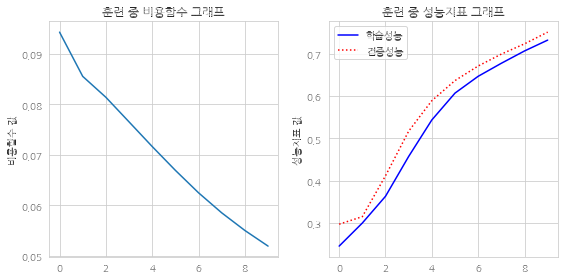

In [19]:
%matplotlib inline
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.title('훈련 중 비용함수 그래프')
plt.ylabel('비용함수 값')
plt.subplot(122)
plt.title('훈련 중 성능지표 그래프')
plt.ylabel('성능지표 값')
plt.plot(hist.history['accuracy'], 'b-', label='학습성능')
plt.plot(hist.history['val_accuracy'], 'r:', label='검증성능')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
hist.history

{'accuracy': [0.24495,
  0.29953334,
  0.36283332,
  0.45718333,
  0.5436,
  0.6071333,
  0.6469167,
  0.6777667,
  0.7069167,
  0.73261666],
 'loss': [0.09428410985817512,
  0.08552267684290807,
  0.08137891297539075,
  0.07650885465244452,
  0.07162582037349542,
  0.06691007668773333,
  0.062465453967452046,
  0.058496335949748755,
  0.05500214258208871,
  0.051910436234126486],
 'val_accuracy': [0.2968,
  0.3147,
  0.4114,
  0.517,
  0.5892,
  0.6368,
  0.6713,
  0.6995,
  0.7238,
  0.7515],
 'val_loss': [0.08708151541650296,
  0.08345305442810058,
  0.07872615084052086,
  0.07371166191995143,
  0.0688850548118353,
  0.06421218294650316,
  0.0599616527184844,
  0.056217179149389264,
  0.05292303577065468,
  0.04998933665454388]}

## 가중치 정보

트레이닝이 끝난 모형의 가중치 정보는 get_weights 메서드로 구할 수 있다. 이 메서드는 신경망 모형에서 사용된 가중치  𝑤  값과  𝑏  값을 출력한다.

In [20]:
# 첫번째 레이어
w1 = l1.get_weights()
w1

[array([[-0.07084247, -0.05559471,  0.06973848, ...,  0.0053319 ,
          0.06608239, -0.04730488],
        [-0.02862956, -0.07614508, -0.07168613, ..., -0.08135189,
          0.02506621, -0.00682919],
        [ 0.07932559, -0.00233051, -0.06288198, ...,  0.02748286,
          0.08029696,  0.01094636],
        ...,
        [ 0.06567308,  0.05978774, -0.05624167, ...,  0.0733607 ,
          0.03726763, -0.07872215],
        [-0.00730155,  0.01829048,  0.01121867, ...,  0.03106049,
         -0.04500397,  0.07734095],
        [-0.06389877, -0.02680947,  0.04098682, ...,  0.03372779,
         -0.00081705,  0.00247288]], dtype=float32),
 array([ 0.02707002, -0.0598399 ,  0.08528825,  0.0221707 , -0.01675528,
         0.14136058, -0.01187399,  0.07995342, -0.02718496,  0.06245353,
        -0.08978144,  0.03537492, -0.04110267, -0.00411568,  0.0740986 ],
       dtype=float32)]

In [21]:
w1[0].shape, w1[1].shape  # w1[0] = 입력 차원 784, layer 15, w1[1] = bias 15

((784, 15), (15,))

In [23]:
# 두번째 레이어
w2 = l2.get_weights()
w2[0].shape, w2[1].shape  # w2[0] : 이전 레이어 15 * 출력 레이어 10, w2[1] = bias 10

((15, 10), (10,))

## 모형의 사용

트레이닝이 끝난 모형은 predict 메서드로 y 값을 출력하거나 출력된 y값을 각 클래스에 대한 판별함수로 가정하고 predict_classes 메서드로 분류를 수행할 수 있다. 

예로 테스트 데이터셋의 첫번째 이미지를 예측하면 다음과 같다.

In [24]:
model.predict(X_test[:1, :])

array([[0.05666983, 0.07294393, 0.0296531 , 0.07808656, 0.08714104,
        0.09773198, 0.02890101, 0.7415826 , 0.08655085, 0.24874878]],
      dtype=float32)

In [26]:
prediction = model.predict(X_test[:1, :])
Y_pred = np.argmax(prediction)
Y_pred

7

7번째 클래스 확률값이 가장 높다

In [28]:
model.predict_classes(X_test[:1, :], verbose=0)

array([7])

테스트 데이터셋의 첫번째 이미지를 출력해보면 다음과 같이 실제로 7이 나온다

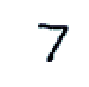

In [29]:
plt.figure(figsize=(1, 1))
plt.imshow(X_test0[0], cmap=mpl.cm.bone_r)
plt.grid(False)
plt.axis('off')
plt.show()

## 모형의 저장

트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 "hdf5" 형식으로 저장하였다가 나중에 load 명령으로 불러 사용할 수 있다.

In [30]:
print(model.predict(X_test[:1, :]))

[[0.05666983 0.07294393 0.0296531  0.07808656 0.08714104 0.09773198
  0.02890101 0.7415826  0.08655085 0.24874878]]


In [31]:
print(model.predict_classes(X_test[:1, :]))

[7]


In [0]:
model.save('my_model.hdf5')
del model

In [35]:
from tensorflow.keras.models import load_model
model2 = load_model('my_model.hdf5')
print(model2.predict_classes(X_test[:1, :], verbose=0))

[7]


### 연습문제 1

Keras를 사용하여 iris 분류 문제를 해결하는 신경망을 구현하라.

In [0]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# 1. 트레인 데이터셋, 테스트 데이터셋 만들기
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [39]:
print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)

(105, 4) float64
(105,) int64


In [40]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [41]:
# 2. y 값을 원핫인코딩 변환
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, 3)
Y_test = to_categorical(y_test, 3)
Y_train[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [0]:
# 3. 신경망 구현
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

np.random.seed(0)

model_iris = Sequential()
model_iris.add(Dense(3, input_dim=4, activation='sigmoid'))  # 활성화함수 뉴런수 설정
model_iris.add(Dense(3, activation='sigmoid'))  # 출력 뉴런수 설정
model_iris.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=['accuracy'])

In [72]:
# 4. 내부구조 확인
model_iris.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 3)                 15        
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 12        
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


In [73]:
# 5. 레이어 특성 검토
l1 = model_iris.layers[0]
l2 = model_iris.layers[1]

print(l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params())
print(l2.name, type(l2), l2.output_shape, l2.activation.__name__, l2.count_params())

dense_13 <class 'tensorflow.python.keras.layers.core.Dense'> (None, 3) sigmoid 15
dense_14 <class 'tensorflow.python.keras.layers.core.Dense'> (None, 3) sigmoid 12


In [74]:
# 6. 트레이닝
%%time
hist = model_iris.fit(X_train, Y_train, epochs=5, batch_size=50, validation_data=(X_test, Y_test), verbose=2)

Train on 105 samples, validate on 45 samples
Epoch 1/5
105/105 - 0s - loss: 0.2860 - accuracy: 0.3714 - val_loss: 0.2838 - val_accuracy: 0.2444
Epoch 2/5
105/105 - 0s - loss: 0.2715 - accuracy: 0.3714 - val_loss: 0.2683 - val_accuracy: 0.2444
Epoch 3/5
105/105 - 0s - loss: 0.2576 - accuracy: 0.3714 - val_loss: 0.2547 - val_accuracy: 0.2444
Epoch 4/5
105/105 - 0s - loss: 0.2464 - accuracy: 0.3714 - val_loss: 0.2472 - val_accuracy: 0.2444
Epoch 5/5
105/105 - 0s - loss: 0.2397 - accuracy: 0.3714 - val_loss: 0.2418 - val_accuracy: 0.2444
CPU times: user 312 ms, sys: 4.44 ms, total: 316 ms
Wall time: 316 ms


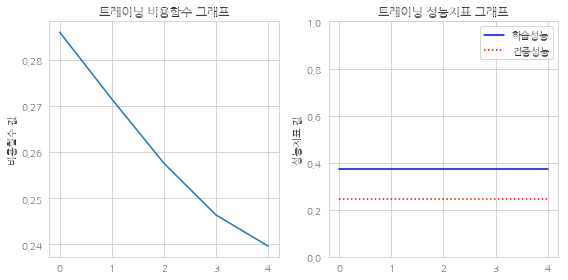

In [75]:
# 7. 비용함수와 성능지표 검토

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.title('트레이닝 비용함수 그래프')
plt.ylabel('비용함수 값')
plt.subplot(122)
plt.title('트레이닝 성능지표 그래프')
plt.ylabel('성능지표 값')
plt.plot(hist.history['accuracy'], 'b-', label='학습성능')
plt.plot(hist.history['val_accuracy'], 'r:', label='검증성능')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
# 8. 가중치 정보 확인
w1 = l1.get_weights()
w2 = l2.get_weights()

print(w1[0].shape, w1[1].shape)
print(w2[0].shape, w2[1].shape)

(4, 3) (3,)
(3, 3) (3,)


In [78]:
# 9. 모형 사용
model_iris.predict_classes(X_test[:1, :], verbose=0)

array([2])

In [80]:
y_test[0]

2

In [0]:
# 10. 모형 저장
model_iris.save('model_iris.hdf5')
del model_iris

In [82]:
# 11. 모형 불러오기
from tensorflow.keras.models import load_model

model_iris2 = load_model('model_iris.hdf5')
print(model_iris2.predict_classes(X_test[:1, :], verbose=0))

[2]


### 연습 문제 2
Keras를 사용하여 olivetti_faces 분류 문제를 해결하는 신경망을 구현하라.

In [113]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

faces = fetch_olivetti_faces()
X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(320, 4096) (320,)
(80, 4096) (80,)


In [114]:
idx = np.random.choice(len(faces.data), 10)
idx

array([314,  38, 169,  34, 209,  70, 131, 379,  91, 167])

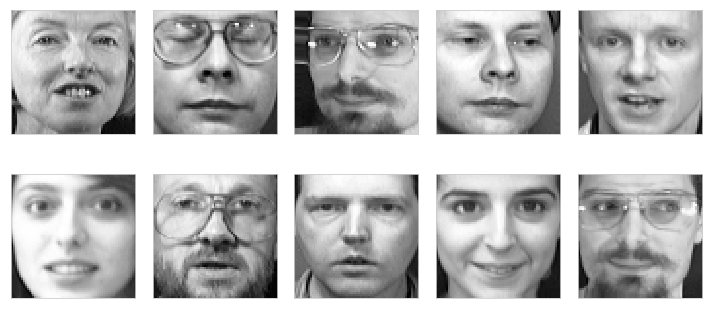

In [115]:
plt.figure(figsize=(10, 5))
for i, id in enumerate(idx):
  plt.subplot(2, 5, i+1)
  plt.imshow(faces.images[id], cmap="gray")
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()
plt.show()

In [116]:
# 타입 확인
print(X_train.dtype, y_train.dtype)

float32 int64


In [117]:
# y 데이터 라벨링 확인
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [0]:
# y데이터 원핫인코딩 변환
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, 40)
Y_test = to_categorical(y_test, 40)

In [0]:
# 신경망 구현
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [0]:
np.random.seed(0)

model_faces = Sequential()
model_faces.add(Dense(60, input_dim=4096, activation='sigmoid'))
model_faces.add(Dense(40, activation='sigmoid'))
model_faces.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=['accuracy'])

In [121]:
model_faces.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 60)                245820    
_________________________________________________________________
dense_18 (Dense)             (None, 40)                2440      
Total params: 248,260
Trainable params: 248,260
Non-trainable params: 0
_________________________________________________________________


In [122]:
# 각 레이어 속성 확인
l1 = model_faces.layers[0]
l2 = model_faces.layers[1]

print(l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params())
print(l2.name, type(l2), l2.output_shape, l2.activation.__name__, l2.count_params())

dense_17 <class 'tensorflow.python.keras.layers.core.Dense'> (None, 60) sigmoid 245820
dense_18 <class 'tensorflow.python.keras.layers.core.Dense'> (None, 40) sigmoid 2440


In [126]:
# 트레이닝
%%time

hist = model_faces.fit(X_train, Y_train, epochs=10, batch_size=20, validation_data=(X_test, Y_test), verbose=2)

Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 - 0s - loss: 0.0310 - accuracy: 0.0469 - val_loss: 0.0306 - val_accuracy: 0.0125
Epoch 2/10
320/320 - 0s - loss: 0.0303 - accuracy: 0.0500 - val_loss: 0.0300 - val_accuracy: 0.0125
Epoch 3/10
320/320 - 0s - loss: 0.0297 - accuracy: 0.0562 - val_loss: 0.0294 - val_accuracy: 0.0125
Epoch 4/10
320/320 - 0s - loss: 0.0292 - accuracy: 0.0562 - val_loss: 0.0290 - val_accuracy: 0.0125
Epoch 5/10
320/320 - 0s - loss: 0.0287 - accuracy: 0.0594 - val_loss: 0.0286 - val_accuracy: 0.0125
Epoch 6/10
320/320 - 0s - loss: 0.0284 - accuracy: 0.0594 - val_loss: 0.0282 - val_accuracy: 0.0125
Epoch 7/10
320/320 - 0s - loss: 0.0280 - accuracy: 0.0594 - val_loss: 0.0279 - val_accuracy: 0.0125
Epoch 8/10
320/320 - 0s - loss: 0.0278 - accuracy: 0.0594 - val_loss: 0.0277 - val_accuracy: 0.0125
Epoch 9/10
320/320 - 0s - loss: 0.0275 - accuracy: 0.0562 - val_loss: 0.0274 - val_accuracy: 0.0125
Epoch 10/10
320/320 - 0s - loss: 0.0273 - accuracy: 0.0

모형 성능이 좋지 않다.

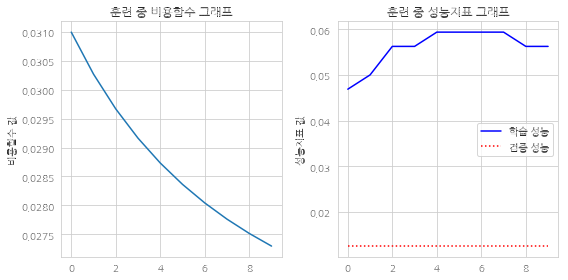

In [127]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.title("훈련 중 비용함수 그래프")
plt.ylabel("비용함수 값")
plt.subplot(1, 2, 2)
plt.title("훈련 중 성능지표 그래프")
plt.ylabel("성능지표 값")
plt.plot(hist.history['accuracy'], 'b-', label="학습 성능")
plt.plot(hist.history['val_accuracy'], 'r:', label="검증 성능")
plt.legend()
plt.tight_layout()
plt.show()